In [1]:
import time
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from datasets import Dataset
from hydra import compose, initialize
from omegaconf import OmegaConf
from sklearn.metrics import roc_auc_score, mean_squared_error

from sklearn.model_selection import StratifiedKFold
from src.seed import seed_everything
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

warnings.filterwarnings("ignore")
with initialize(config_path="config", version_base=None):
    cfg = compose(config_name="config")
    cfg.exp_number = Path().resolve().name

print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


lgb:
  params:
    objective: binary
    metric: auc
    verbose: -1
    boosting_type: gbdt
    learning_rate: 0.01
    max_depth: 5
    num_leaves: 31
    min_data_in_leaf: 50
    bagging_fraction: 0.8
    bagging_freq: 1
    feature_fraction: 0.8
    lambda_l1: 0
    lambda_l2: 1
    seed: 42
  early_stopping_rounds: 100
  log_evaluation: 100
  num_boost_round: 10000000
bert:
  params:
    model_path: microsoft/deberta-v3-large
    metric: auc
    target_col_class_num: 3
    max_length: 192
    fp16: true
    learning_rate: 2.0e-05
    epochs: 2
    per_device_train_batch_size: 8
    per_device_eval_batch_size: 32
    steps: 50
    lr_scheduler_type: linear
    weight_decay: 0.01
exp_number: '006'
run_name: base
data:
  data_root: ../../data
  results_root: ../../results
  train_path: ../../data/train.csv
  clothing_path: ../../data/clothing_master.csv
  test_path: ../../data/test.csv
  sample_submission_path: ../../data/sample_submission.csv
  results_dir: ../../results/006/base
se

### Import

In [2]:
debug = False

train_df = pd.read_csv(cfg.data.train_path)
clothing_df = pd.read_csv(cfg.data.clothing_path)
test_df = pd.read_csv(cfg.data.test_path)

if debug:
    train_df = train_df.sample(2000, random_state=cfg.seed).reset_index(drop=True)

def preprocess(df):
    """
    BERTモデルに入力するテキストを作成
    他のカラムを組み合わせる or [SEP][CLS]などを組み合わせるなど工夫の余地ある?
    """
    df["prompt"] = "TITLE: " + df["Title"].fillna("none") + " [SEP] " + "REVIEW: " + df["Review Text"].fillna("none")
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)
train_df["labels"] = train_df[cfg.target].astype(np.int8)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=cfg.seed)


In [3]:
def compute_metrics(p):
    """AUCを計算する"""
    preds, labels = p
    main_labels = labels[0]
    aux_labels = labels[1]
    main_preds = preds[:, 2]
    aux_preds = preds[:, 2]

    main_preds = torch.softmax(torch.tensor(preds), dim=1).numpy()
    score = roc_auc_score(main_labels, main_preds[:, 1])

    aux_score = mean_squared_error(aux_labels, aux_preds)

    return {'auc': score, 'mse': aux_score}

def tokenize(sample):
    """文字列をトークン化する"""
    return tokenizer(
        sample['prompt'],
        max_length=cfg.bert.params.max_length,  # モデルの最大入力長. Title+REVIEWだけだと192くらいあれば十分
        truncation=True  # 最大入力長を超えた場合に切り捨てるかどうか
    )

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        ratings = inputs.pop("Rating")

        outputs = model(**inputs)
        logits = outputs.get("logits")

        # メインのクロスエントロピー損失
        loss_fct = nn.CrossEntropyLoss()
        main_loss = loss_fct(logits[:, :2].view(-1, 2), labels.view(-1))

        # 補助損失の計算（回帰問題のMSE損失）
        aux_loss_fct = nn.MSELoss()
        aux_loss = aux_loss_fct(logits[:, 2], ratings.float())

        # 総損失 = メイン損失 + 補助損失
        total_loss = main_loss + 0.0001 * aux_loss  # 0.01は補助損失の重み
        # total_loss = main_loss

        return (total_loss, outputs) if return_outputs else total_loss

# 実験結果格納用のディレクトリを作成
cfg.run_name = time.strftime("%Y%m%d_%H%M%S")
Path(cfg.data.results_dir).mkdir(exist_ok=True, parents=True)

y_train = train_df[cfg.target]
oof = np.zeros(len(train_df))

for fold, (train_index, valid_index) in enumerate(kf.split(train_df, y_train)):

    if fold <= 1:
        continue

    ds_train = Dataset.from_pandas(train_df.iloc[train_index][['prompt', 'labels', "Rating"]].copy())
    ds_eval = Dataset.from_pandas(train_df.iloc[valid_index][['prompt', 'labels', "Rating"]].copy())

    tokenizer = AutoTokenizer.from_pretrained(cfg.bert.params.model_path)
    config = AutoConfig.from_pretrained(cfg.bert.params.model_path, num_labels=cfg.bert.params.target_col_class_num)
    model = AutoModelForSequenceClassification.from_pretrained(cfg.bert.params.model_path, config=config)
    model.to(device)

    ds_train = ds_train.map(tokenize).remove_columns(['prompt', '__index_level_0__'])
    ds_eval = ds_eval.map(tokenize).remove_columns(['prompt', '__index_level_0__'])

    output_dir = f"{cfg.data.results_dir}/fold{fold}"

    train_args = TrainingArguments(
        output_dir=output_dir,  # 出力先ディレクトリ
        fp16=cfg.bert.params.fp16,  # 16bit精度を使用するかどうか. Trueにすると高速化されるが、精度が落ちる可能性がある
        learning_rate=cfg.bert.params.learning_rate,
        num_train_epochs=cfg.bert.params.epochs,  # 学習エポック数
        per_device_train_batch_size=cfg.bert.params.per_device_train_batch_size,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        gradient_accumulation_steps=4,  # 逆伝播のステップ数. どう影響する??
        report_to="none",
        evaluation_strategy="steps",  # 評価を行うタイミング. stepsにするとstepsごとに評価が行われる
        do_eval=True,  # 評価を行うかどうか
        eval_steps=cfg.bert.params.steps,  # 評価を行うステップ数
        save_total_limit=1,  # 保存するモデルの数. 3にすると過去3回分のモデルが保存される
        save_strategy="steps",  # モデルの保存タイミング. stepsにするとstepsごとにモデルが保存される
        save_steps=cfg.bert.params.steps,  # モデルの保存ステップ数
        logging_steps=cfg.bert.params.steps,  # ログを出力するステップ数
        load_best_model_at_end=True,  # 最良のモデルを最後にロードするかどうか
        lr_scheduler_type=cfg.bert.params.lr_scheduler_type,  # 学習率のスケジューラの種類. linear or cosineの両方試しておきたい
        metric_for_best_model=cfg.bert.params.metric,  # 最良のモデルを選択するメトリック
        greater_is_better=True,  # 最良のモデルを選択する際に、metric_for_best_modelが大きいほど良いかどうか
        warmup_ratio=0.1,  # warmupの割合. [0.0, 0.1, 0.01]のどれかを使うのが一般的
        weight_decay=cfg.bert.params.weight_decay,  # 重み減衰の割合. 0.01が一般的. もしくは0.0
        seed=cfg.seed,
        data_seed=cfg.seed,
        label_names=["labels", "Rating"],  # ラベルのカラム名
    )

    trainer = CustomTrainer(
        model=model,
        args=train_args,
        train_dataset=ds_train,
        eval_dataset=ds_eval,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    final_output_dir = f"{cfg.data.results_dir}/fold{fold}/final"
    trainer.save_model(final_output_dir)
    tokenizer.save_pretrained(final_output_dir)

    pred = torch.softmax(torch.tensor(trainer.predict(ds_eval).predictions)[:, :2], dim=1).numpy()
    oof[valid_index] = pred[:, 1]


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc,Mse
50,0.512700,0.266088,0.945086,20.714634
100,0.287400,0.200050,0.964618,16.515337
150,0.205800,0.188380,0.969169,12.302349
200,0.184600,0.194676,0.971265,10.236436
250,0.164400,0.180344,0.971275,8.404572
300,0.160300,0.222472,0.970099,7.165946
350,0.119100,0.188569,0.973608,5.625254
400,0.153600,0.174585,0.974058,4.938533
450,0.163500,0.172799,0.970843,5.050899
500,0.126200,0.172063,0.970644,4.583276


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc,Mse
50,0.475400,0.305775,0.845589,15.876536
100,0.261900,0.242364,0.956320,12.972287
150,0.198900,0.249681,0.953939,10.979209
200,0.239700,0.207180,0.961406,8.058406
250,0.203800,0.184283,0.965349,6.874112
300,0.146100,0.257487,0.960886,5.195500
350,0.169900,0.190403,0.963745,4.146759
400,0.124200,0.194419,0.965793,3.365550
450,0.131700,0.210605,0.965704,3.245699
500,0.154800,0.190749,0.966293,3.401401


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Auc,Mse
50,0.446100,0.484114,0.793480,15.167320
100,0.368400,0.214679,0.956680,13.423169
150,0.245700,0.200819,0.969595,10.726672
200,0.194900,0.172719,0.972497,8.816696
250,0.190000,0.174559,0.971565,6.913114
300,0.157600,0.191421,0.969118,5.206735
350,0.134900,0.183468,0.971291,4.479638
400,0.143700,0.172914,0.972242,4.255853
450,0.156300,0.173624,0.971723,3.761607
500,0.142500,0.169699,0.972166,3.657753


### oof

score: 0.9218426017596624


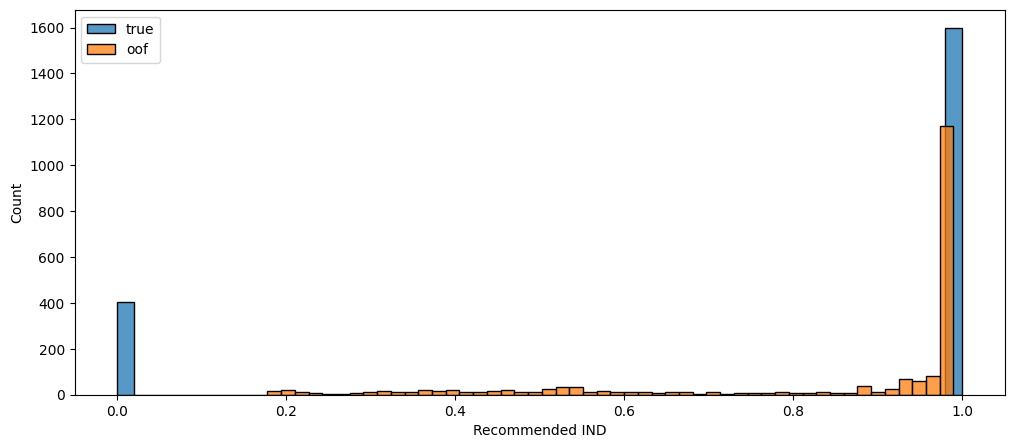

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

oof_df = pd.DataFrame({"oof": oof})
oof_df.to_csv(f"{cfg.data.results_dir}/oof.csv", index=False)

best_score = roc_auc_score(y_train, oof)
print(f"score: {best_score}")
with open(f"{cfg.data.results_dir}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

fig, ax = plt.subplots(figsize=(12, 5))
sns.histplot(y_train, bins=50)
sns.histplot(oof, bins=50)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_dir}/oof_hist.png")


### SUbmission

In [4]:
import os

preds = []
for i in range(5):
    fold_dir = f"{cfg.data.results_dir}/fold{fold}"
    checkpoint_dirs = [d for d in os.listdir(fold_dir) if d.startswith("checkpoint-")]
    results_dir = os.path.join(fold_dir, checkpoint_dirs[0])
    model = AutoModelForSequenceClassification.from_pretrained(results_dir)

    ds_test = Dataset.from_pandas(test_df[['prompt']].copy())
    ds_test = ds_test.map(tokenize).remove_columns(['prompt'])

    test_args = TrainingArguments(
        output_dir=cfg.data.results_dir,
        per_device_eval_batch_size=cfg.bert.params.per_device_eval_batch_size,
        do_predict=True,
        dataloader_drop_last=False,
    )
    trainer = Trainer(
        model=model,
        args=test_args,
        data_collator=DataCollatorWithPadding(tokenizer),
        tokenizer=tokenizer,
    )
    predictions = torch.softmax(torch.tensor(trainer.predict(ds_test).predictions)[:, :2], dim=1).numpy()
    preds.append(predictions[:, 1])

pred = np.mean(preds, axis=0)

# 提出用ファイル作成
sub_df = pd.read_csv(cfg.data.sample_submission_path)
sub_df["target"] = pred
sub_df.to_csv(f"{cfg.data.results_dir}/{cfg.run_name}_submission.csv", index=False)
sub_df.head()


Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

Map:   0%|          | 0/11155 [00:00<?, ? examples/s]

,target
0,0.998374
1,0.170715
2,0.994989
3,0.245266
4,0.997172


<Axes: ylabel='Count'>

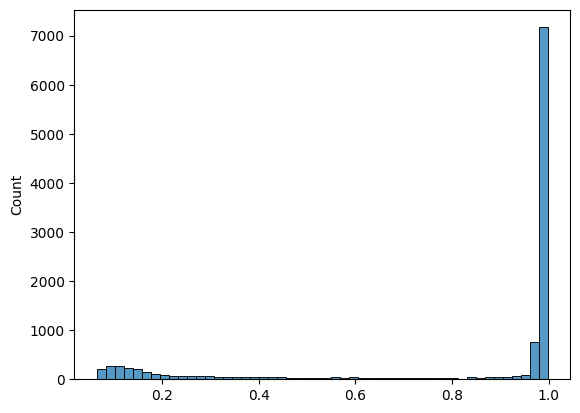

In [6]:
import seaborn as sns

sns.histplot(pred, bins=50)
